<html><h1><center style="color:blue">Applying LSTM Models on Raw Data</center></h1></html>

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import tensorflow as tf

# Suppress TensorFlow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Import Keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.regularizers import L1L2

In [2]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# function to print the confusion matrix

def confusion_matrix(Y_true, Y_pred):
    
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

    
   # result = confusion_matrix(Y_true, Y_pred)

    #plt.figure(figsize=(10, 8))
   # sns.heatmap(result, 
    #            xticklabels= list(ACTIVITIES.values()), 
     #           yticklabels=list(ACTIVITIES.values()), 
      #          annot=True, fmt="d");
   # plt.title("Confusion matrix")
   # plt.ylabel('True label')
   # plt.xlabel('Predicted label')
    plt.show()  

<html><h1><p style="color:red">Loading Data / Making Data </p></h1></html>

In [4]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
    ]

In [5]:
# function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).to_numpy()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [6]:
def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).to_numpy()

In [7]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [8]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

In [9]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32

In [10]:
#function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [11]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

C:\Users\sanju\AppData\Local\Temp\ipykernel_28288\618491832.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(filename, delim_whitespace=True, header=None)
C:\Users\sanju\AppData\Local\Temp\ipykernel_28288\618491832.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(filename, delim_whitespace=True, header=None)
C:\Users\sanju\AppData\Local\Temp\ipykernel_28288\618491832.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(filename, delim_whitespace=True, header=None)
C:\Users\sanju\AppData\Local\Temp\ipykernel_28288\618491832.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future ve

In [12]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


<html><h1><p style="color:red">1. Defining the Architecture of 1-Layer of LSTM </p></h1></html>

In [13]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                5376      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 6)                 198       
                                                                 
Total params: 5574 (21.77 KB)
Trainable params: 5574 (21.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [15]:
# Training the model
model.fit(X_train, Y_train, batch_size=batch_size, validation_data=(X_test, Y_test),epochs=epochs)

Epoch 1/30
460/460 [==============================] - 11s 20ms/step - loss: 1.1604 - accuracy: 0.5135 - val_loss: 0.9440 - val_accuracy: 0.5999
Epoch 2/30
460/460 [==============================] - 9s 19ms/step - loss: 0.8015 - accuracy: 0.6699 - val_loss: 0.6867 - val_accuracy: 0.7245
Epoch 3/30
460/460 [==============================] - 9s 19ms/step - loss: 0.5664 - accuracy: 0.8035 - val_loss: 0.5679 - val_accuracy: 0.8120
Epoch 4/30
460/460 [==============================] - 9s 19ms/step - loss: 0.4052 - accuracy: 0.8788 - val_loss: 0.4975 - val_accuracy: 0.8446
Epoch 5/30
460/460 [==============================] - 9s 19ms/step - loss: 0.3365 - accuracy: 0.9036 - val_loss: 0.4502 - val_accuracy: 0.8649
Epoch 6/30
460/460 [==============================] - 9s 19ms/step - loss: 0.2811 - accuracy: 0.9178 - val_loss: 0.9910 - val_accuracy: 0.7506
Epoch 7/30
460/460 [==============================] - 9s 19ms/step - loss: 0.2375 - accuracy: 0.9264 - val_loss: 0.7365 - val_accuracy: 0.835

93/93 [==============================] - 1s 7ms/step


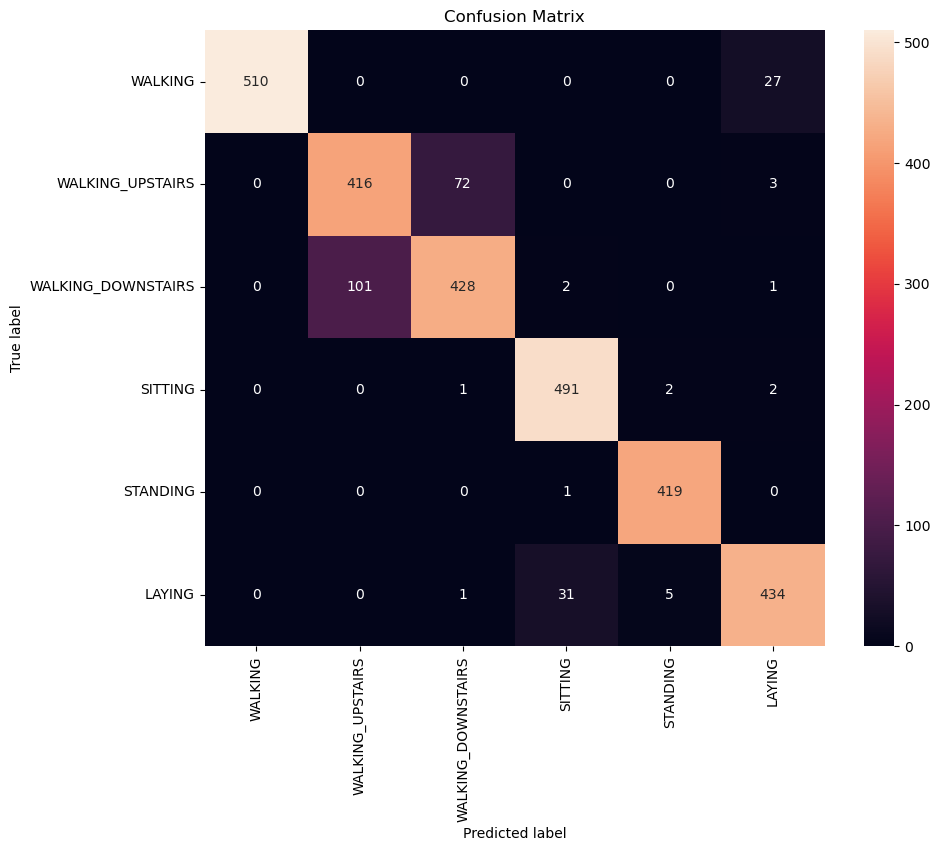

In [17]:
# Confusion Matrix
result = confusion_matrix(Y_test, model.predict(X_test))

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(result, 
            xticklabels=list(ACTIVITIES.values()), 
            yticklabels=list(ACTIVITIES.values()), 
            annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [18]:
score = model.evaluate(X_test, Y_test)

print("\n   cat_crossentropy  ||   accuracy ")
print("  ____________________________________")
print(score)

93/93 [==============================] - 1s 7ms/step - loss: 0.3155 - accuracy: 0.9155

   cat_crossentropy  ||   accuracy 
  ____________________________________
[0.31551265716552734, 0.9155073165893555]


<html><h3><p style="color:#008080">With a simple 1 layer architecture we got 90.09% accuracy and a loss of 0.47</p></h4></html>

<html><h1><p style="color:red">2. Defining the Architecture of 2-Layer of LSTM with more hyperparameter tunning </p></h1></html>

### 2.1 First Model for 2-Layer of LSTM with more hyperparameter tunning

In [19]:
# Initializing parameters
n_epochs = 30
n_batch = 16
n_classes = _count_classes(Y_train)

# Bias regularizer value - we will use elasticnet
reg = L1L2(0.01, 0.01)

In [20]:
# Model execution
model = Sequential()
model.add(LSTM(48, input_shape=(timesteps, input_dim), return_sequences=True,bias_regularizer=reg ))
model.add(BatchNormalization())
model.add(Dropout(0.50))
model.add(LSTM(32))
model.add(Dropout(0.50))
model.add(Dense(n_classes, activation='sigmoid'))
print("Model Summary: ")
model.summary()

Model Summary: 
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128, 48)           11136     
                                                                 
 batch_normalization (Batch  (None, 128, 48)           192       
 Normalization)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 128, 48)           0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                10368     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 198       
                                      

In [21]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
# Training the model
model.fit(X_train, Y_train, batch_size=n_batch, validation_data=(X_test, Y_test), epochs=n_epochs)

Epoch 1/30
460/460 [==============================] - 25s 46ms/step - loss: 1.5057 - accuracy: 0.6897 - val_loss: 1.0108 - val_accuracy: 0.8100
Epoch 2/30
460/460 [==============================] - 20s 44ms/step - loss: 0.6723 - accuracy: 0.8885 - val_loss: 0.5567 - val_accuracy: 0.8663
Epoch 3/30
460/460 [==============================] - 20s 44ms/step - loss: 0.3914 - accuracy: 0.9075 - val_loss: 0.5047 - val_accuracy: 0.8517
Epoch 4/30
460/460 [==============================] - 20s 43ms/step - loss: 0.2575 - accuracy: 0.9230 - val_loss: 0.3474 - val_accuracy: 0.8870
Epoch 5/30
460/460 [==============================] - 20s 43ms/step - loss: 0.2109 - accuracy: 0.9321 - val_loss: 0.2744 - val_accuracy: 0.9141
Epoch 6/30
460/460 [==============================] - 20s 43ms/step - loss: 0.1691 - accuracy: 0.9392 - val_loss: 0.3690 - val_accuracy: 0.8958
Epoch 7/30
460/460 [==============================] - 20s 43ms/step - loss: 0.1868 - accuracy: 0.9348 - val_loss: 0.3541 - val_accuracy:

93/93 [==============================] - 2s 15ms/step


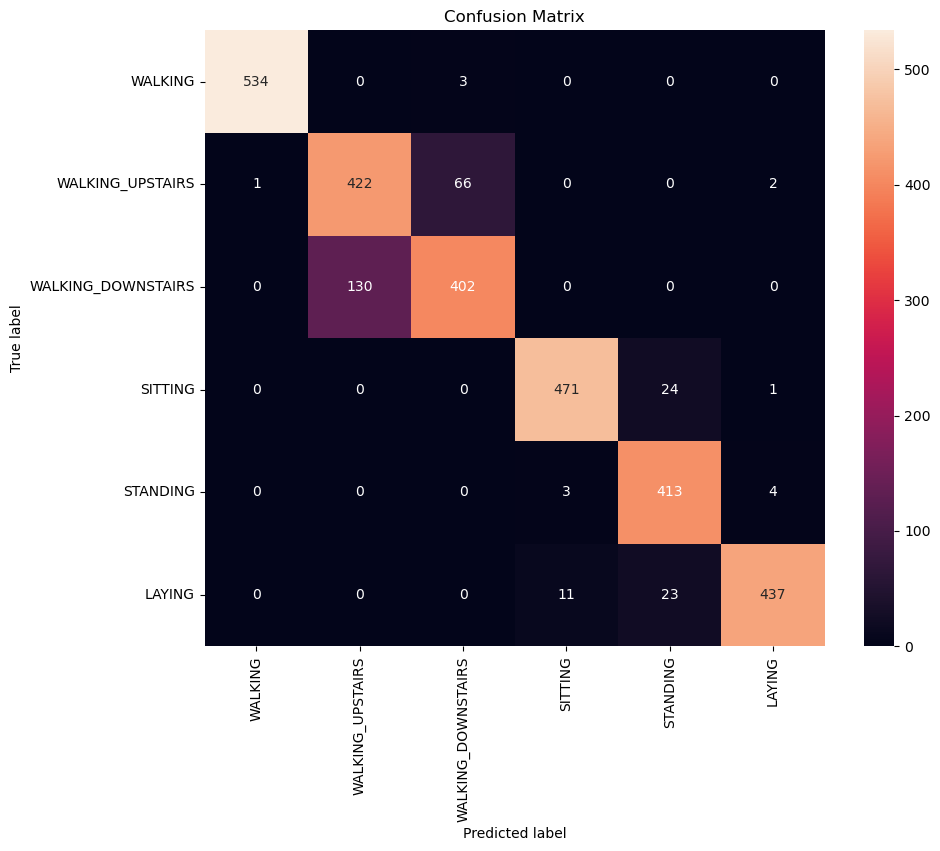

In [23]:
# Confusion Matrix
result1 = confusion_matrix(Y_test, model.predict(X_test))

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(result1, 
            xticklabels=list(ACTIVITIES.values()), 
            yticklabels=list(ACTIVITIES.values()), 
            annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [24]:
score = model.evaluate(X_test, Y_test)

print("\n   cat_crossentropy  ||   accuracy ")
print("  ____________________________________")
print(score)

93/93 [==============================] - 1s 15ms/step - loss: 0.3266 - accuracy: 0.9091

   cat_crossentropy  ||   accuracy 
  ____________________________________
[0.32658901810646057, 0.9090600609779358]


### 2.2 Second Model for 2-Layer of LSTM with more hyperparameter tunning

In [25]:
# Model execution
model = Sequential()
model.add(LSTM(64, input_shape=(timesteps, input_dim), return_sequences=True, bias_regularizer=reg))
model.add(BatchNormalization())
model.add(Dropout(0.50))
model.add(LSTM(48))
model.add(Dropout(0.50))
model.add(Dense(n_classes, activation='sigmoid'))
print("Model Summary: ")
model.summary()

Model Summary: 
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 128, 64)           18944     
                                                                 
 batch_normalization_1 (Bat  (None, 128, 64)           256       
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 128, 64)           0         
                                                                 
 lstm_4 (LSTM)               (None, 48)                21696     
                                                                 
 dropout_4 (Dropout)         (None, 48)                0         
                                                                 
 dense_2 (Dense)             (None, 6)                 294       
                                      

In [26]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
# Training the model
model.fit(X_train, Y_train, batch_size=n_batch, validation_data=(X_test, Y_test), epochs=n_epochs)

Epoch 1/30
460/460 [==============================] - 25s 46ms/step - loss: 1.6424 - accuracy: 0.7250 - val_loss: 1.1233 - val_accuracy: 0.8219
Epoch 2/30
460/460 [==============================] - 20s 45ms/step - loss: 0.7490 - accuracy: 0.8930 - val_loss: 0.6395 - val_accuracy: 0.8724
Epoch 3/30
460/460 [==============================] - 21s 45ms/step - loss: 0.3951 - accuracy: 0.9184 - val_loss: 0.3765 - val_accuracy: 0.8972
Epoch 4/30
460/460 [==============================] - 20s 44ms/step - loss: 0.2245 - accuracy: 0.9346 - val_loss: 0.3035 - val_accuracy: 0.8904
Epoch 5/30
460/460 [==============================] - 21s 45ms/step - loss: 0.1931 - accuracy: 0.9358 - val_loss: 0.3317 - val_accuracy: 0.8972
Epoch 6/30
460/460 [==============================] - 21s 45ms/step - loss: 0.1714 - accuracy: 0.9363 - val_loss: 0.3050 - val_accuracy: 0.9121
Epoch 7/30
460/460 [==============================] - 21s 45ms/step - loss: 0.1637 - accuracy: 0.9407 - val_loss: 0.2686 - val_accuracy:

93/93 [==============================] - 3s 17ms/step


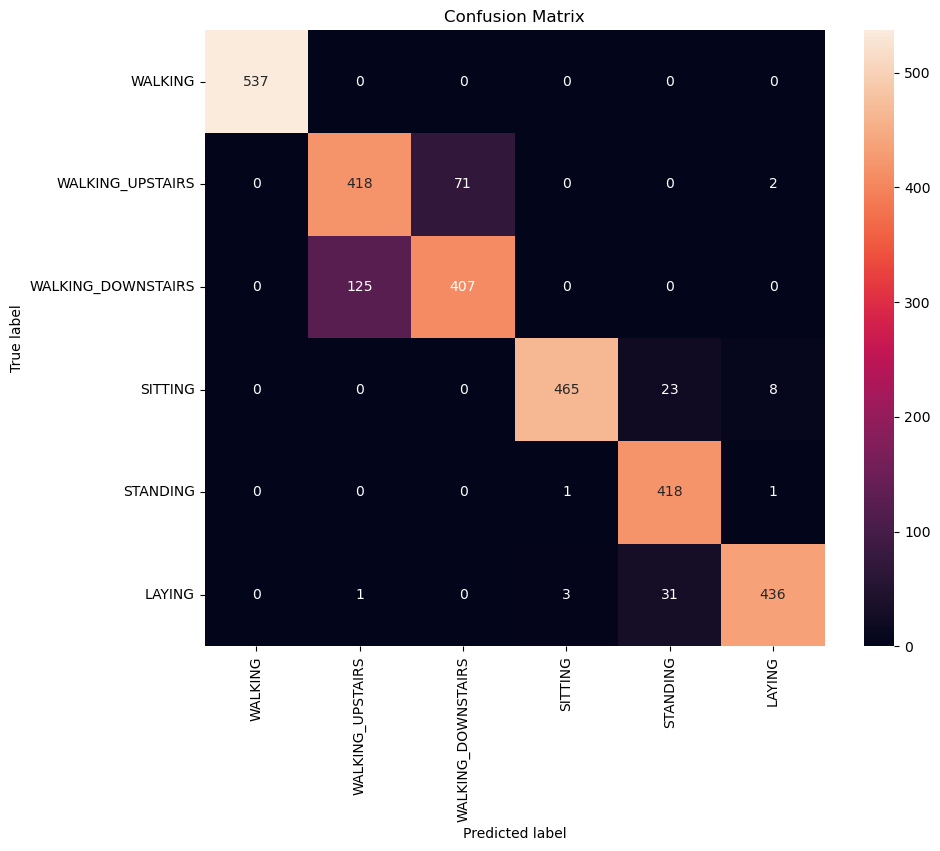

In [28]:
# Confusion Matrix
result2 = confusion_matrix(Y_test, model.predict(X_test))

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(result2, 
            xticklabels=list(ACTIVITIES.values()), 
            yticklabels=list(ACTIVITIES.values()), 
            annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [29]:
score = model.evaluate(X_test, Y_test)

print("\n   cat_crossentropy  ||   accuracy ")
print("  ____________________________________")
print(score)

93/93 [==============================] - 2s 18ms/step - loss: 0.2966 - accuracy: 0.9097

   cat_crossentropy  ||   accuracy 
  ____________________________________
[0.29664888978004456, 0.9097387194633484]
